In [1]:
import numpy as np
import pandas as pd
!pip install pymc==5.0.2
from src.models import get_belief_model
from scipy.special import expit
import pymc as pm
import arviz as az
import json
import os
import seaborn as sns




def make_dir(newpath):
    if not os.path.exists(newpath):
        os.makedirs(newpath)

use_cpu = True   
try: 
    import pymc.sampling.jax as pmjaxz
    from jax.lib import xla_bridge
    import matplotlib.pyplot as plt
    print(xla_bridge.get_backend().platform)
    if xla_bridge.get_backend().platform == 'gpu':
        use_cpu = False
    import pymc.sampling.jax as pmjax
except:
    print("No JAX backend")
    use_cpu = True

params = json.load(open('params.json'))
np.random.seed(params['seed'])

%load_ext autoreload
%autoreload 2
%autosave 30

gpu


/home/jbb2191/anaconda3/envs/mlc/lib/python3.10/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


Autosaving every 30 seconds


# Step One: Conceptual Analysis
Participants, from various countries, have been asked to engage in a cognitively taxing task to plant up to eight trees. 


# Step Two: Define Conceptual Space
Outcomes are integers between 0 and 8. 

# Step Three: Construct summary statistics 
We will not create any specific summary statsitics. 

# Step Four: Model Development
Our outcome variable (WEPT), examines the number of tasks completed to plant trees. It is quite clearly not normally distributed, with nearly half of all participants planting the maximum number of trees. Otherwise, the most typical response was to plant zero trees, with 6-7 trees being the most likely. We construct a custom liklihood function that is a mixture of a geometric distribution and inflation at the maximum value. This captures "giving up" and "commitment to all trees". Note that we add 1 to the outcome variable to meet requirements of our geometric distribution. During analysis, this is removed. 

\begin{align}
y&\sim=\text{MaxInflatedGeom}(p_i, \theta, U, L)\\
U&=1\\
L&=9\\
p_i &= \frac{1}{(1 + \mu_{p,i}  (U - 1))}\\
\theta &= \mu_t\\
\text{logit}(\mu_p) &= \alpha_p + \beta_p  X + \text{C}_{0, c[i]} +  \text{C}_{1,c[i]}X +  \text{T}_{0, t[i]} + \text{T}_{0, t[i]} X \\
\text{logit}(\mu_t) &= \alpha_t + \beta_t  X + \text{C}_{2, c[i]} +  \text{C}_{3,c[i]}X +  \text{T}_{2, t[i]} + \text{T}_{3, t[i]} X \\
\alpha &= \text{Normal}(-1, 1)\\
\beta &= \text{Normal}(0, 1)\\
C, T&\sim \text{MVNormal} \big(\begin{bmatrix}0\\0\\0\\0\end{bmatrix},S\big)\\
I&=\big(\begin{matrix}\sigma & 0 & 0 & 0 \\ 0 & \sigma  & 0 & 0 \\ 0 &0  & \sigma & 0  \\ 0 &0  & 0 & \sigma  \end{matrix}\big)\\
S&= IRI\\
R &\sim{LKJCorr(4)}\\


\end{align}

We note a custom link function for $p_i$, such that the expectation of $p_i\approx\theta_i$




# Step Five: Construct Summary Statistics
We will qualitatively assess trees planning, across prior simulations. No summary statistics will be constructed

In [2]:
import pandas as pd
df = pd.read_excel(params['data']['adj_location'])
df.head()

,Unnamed: 0,ResponseId,country,cond,condName,Intervention_order,Belief1,Belief2,Belief3,Belief4,...,Indirect_SES,MacArthur_SES,PerceivedSciConsensu_1,Intro_Timer,WEPTcc,BeliefCC,PolicyCC,Country,UniqueID,BeliefADJ
0,0,R_1r7Yr7R1xMimIvj,usa,5,CollectAction,BeliefinAnthrCC|SocialmediasharingPipedText|Po...,98.0,77.0,86.0,93.0,...,"2,4,5",7.0,80.0,6.056,1,88.50,89.000000,usa,0,1.601461
1,1,R_2ATgV5VxewrTRiI,usa,1,Control,PolicySupport|BeliefinAnthrCC|Socialmediashari...,49.0,50.0,51.0,51.0,...,"1,2,3,4,5,6,7",5.0,51.0,16.284,0,50.25,66.222222,usa,1,0.061524
2,2,R_3ENlePBlLyYjExr,usa,9,Letter2Future,SocialmediasharingPipedText|PolicySupport|Beli...,87.0,82.0,84.0,83.0,...,"1,2,3,6,7",8.0,73.0,5.701,1,84.00,84.222222,usa,2,1.264478
3,3,R_2c0HQgvYzas6mus,usa,4,SciConsens,PolicySupport|SocialmediasharingPipedText|Beli...,1.0,1.0,0.0,0.0,...,"1,2,3,4,5,6,7",4.0,1.0,13.282,0,0.50,1.222222,usa,3,-2.516294
4,4,R_00siryCwgdMus6J,usa,8,PluralIgnorance,BeliefinAnthrCC|SocialmediasharingPipedText|Po...,56.0,59.0,61.0,54.0,...,"1,3,5,6,7",7.0,65.0,8.474,0,57.50,80.222222,usa,4,0.300307


In [3]:
params = json.load(open('params.json'))
params['wept']['priors']

{'lambda_val': 1, 'beta_geom_sigma': 1, 'beta_theta_sigma': 1}

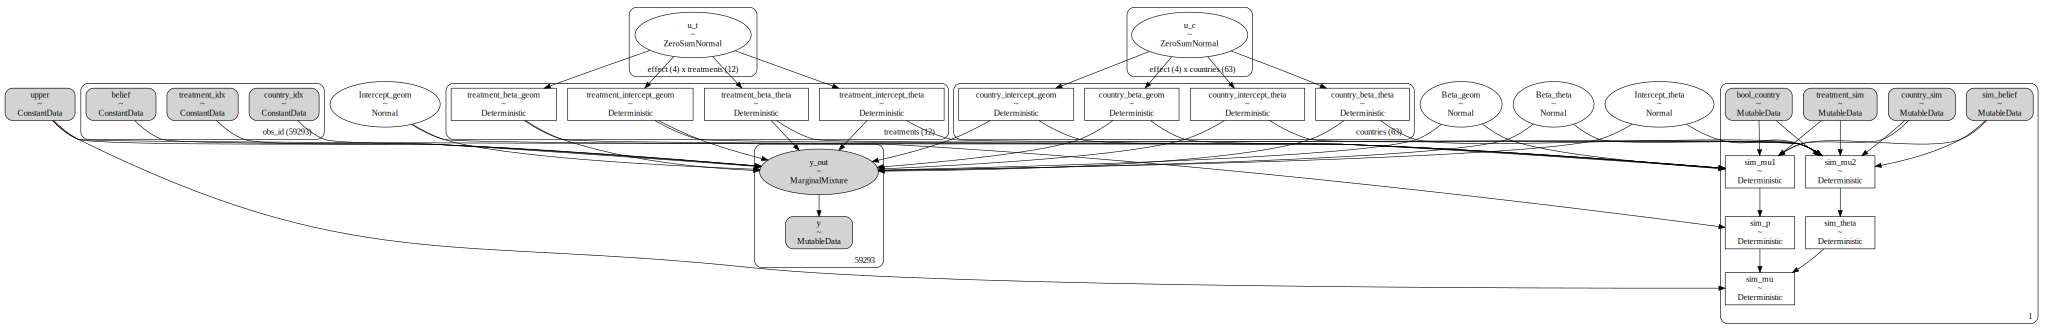

In [4]:
from src.models import get_WEPT_model


model, temp = get_WEPT_model(df, priors = params['wept']['priors'])

pm.model_to_graphviz(model)

# Step Six: Simulate Bayesian Ensemble

With our priors and model loaded, we can simulate the implications of our structure and prior choice to determine whether we have chosen appropriate priors. Should they appear off, they can be adjusted in `params.json` and reloaded. 


In [5]:
with model: 
    prior_predictive = pm.sample_prior_predictive(samples = params['wept']['prior_predictive_samples'],
                                                  random_seed=params['seed'])

az.to_netcdf(prior_predictive, './out/posteriors/prior_predictive_wept.nc')

/home/jbb2191/.local/lib/python3.10/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Sampling: [Beta_geom, Beta_theta, Intercept_geom, Intercept_theta, u_c, u_t, y_out]


'./out/posteriors/prior_predictive_wept.nc'

# Step seven: Prior Predictive Checks
Here, we verify that our prior choices produce distributions of sharing consistent with our domain knowledge. We want to ensure we have inflation at the max value, and plausible distributions for the lower portion of the range

/tmp/ipykernel_116071/453205677.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


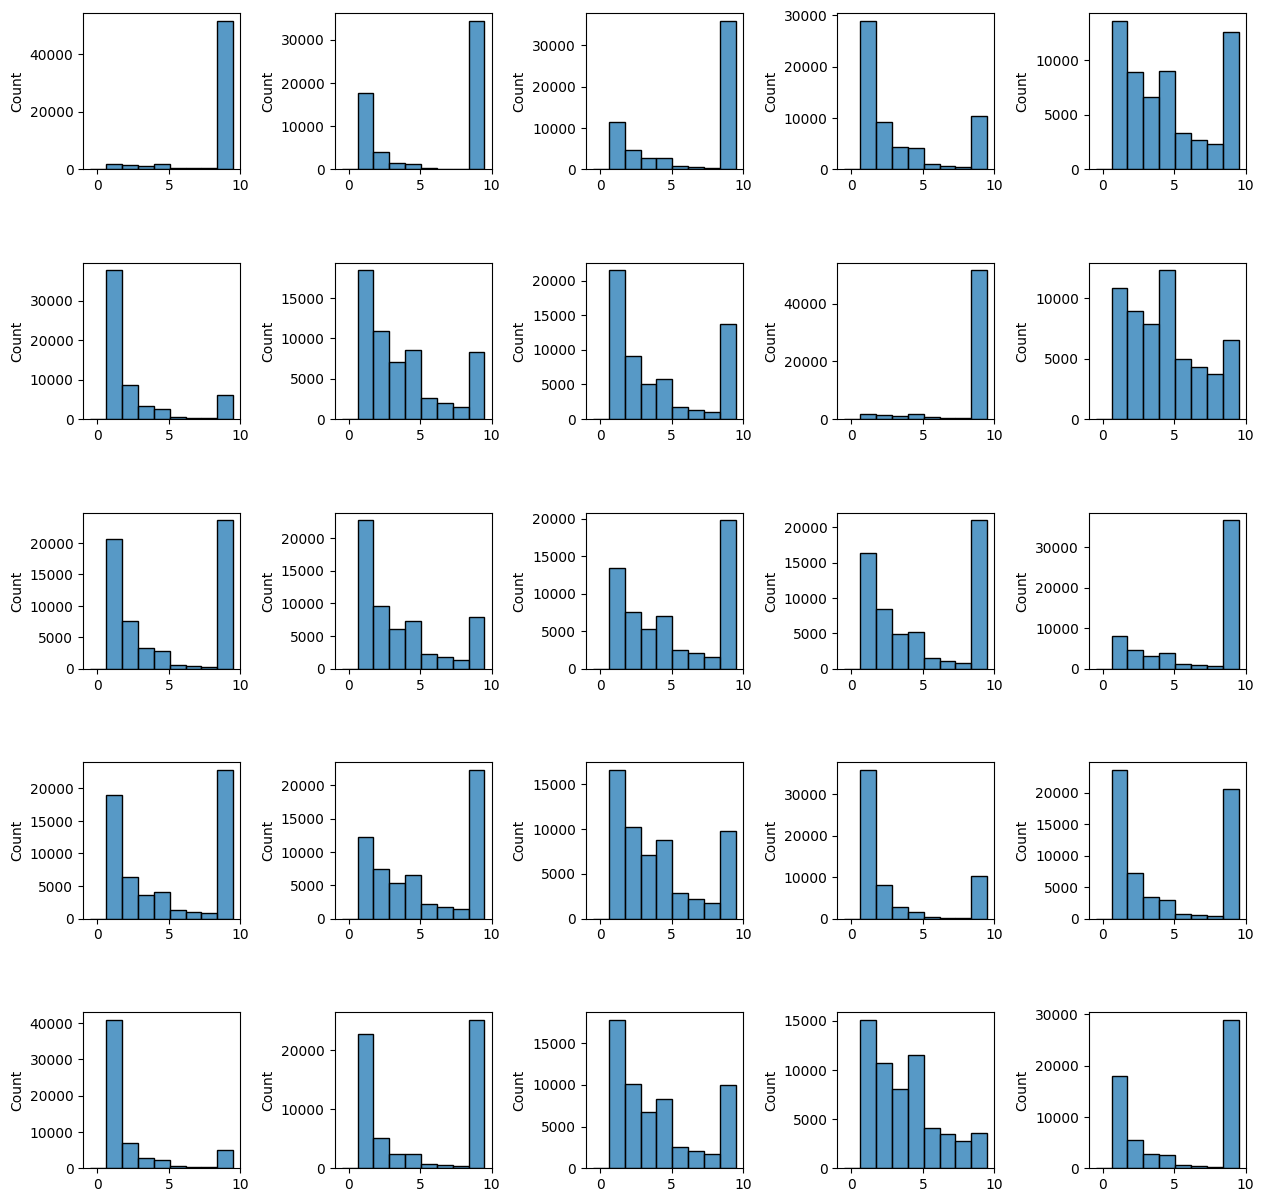

In [6]:
prior_pd = prior_predictive.prior_predictive['y_out']

plt.figure(figsize=(15, 15))
g = plt.GridSpec(5, 5, hspace=0.6, wspace=0.6)

for i in range(5):
    for j in range(5):
        ax = plt.subplot(g[i, j])
        sns.histplot(prior_pd[0, np.random.choice(np.arange(prior_pd.shape[1])), :], 
                     bins=np.linspace(-0.5, 9.5, 10))
plt.tight_layout()



# Step Eight: Configure Algorithm
We will use default parameters to sample on the GPU. Tune and Draw can be adjusted in params.json

# Step Nine: Fit Simulated Ensemble
As this is computationally challenging, we face some trade-offs between running the model at the full data volume and running the model on sufficient numbers of prior samples to draw conclusions about the inferential adequacy. We will run only 6 fits from the prior distribution. 


In [7]:
#Add zero constrain on control treatment effects. 
from pymc.sampling import jax as pmjax
prior_num = 0

for prior_num in np.random.choice(np.arange(params['wept']['prior_predictive_samples']), size=1):
    print('Running inference on prior sample: ', prior_num)
    ranked_data = []
    with model:
        model.set_data('y', prior_predictive.prior_predictive['y_out'].data[0][prior_num])
        if use_cpu:
            idata = pm.sample(tune = params['wept']['tune'], draws = params['wept']['draws'], random_seed=params['seed'])
        else: 
            idata = pmjax.sample_numpyro_nuts(chain_method=params['sampling']['chain_method'],
                                        postprocessing_backend=params['sampling']['postprocessing_backend'], 
                                        tune =500, 
                                        draws = 500, random_seed=params['seed'])
        
        out = []
        var_names = ['u_t', 'u_c', 'Intercept_geom', 'Beta_geom',
                     'Intercept_theta', 'Beta_theta']
        for name in var_names:
            ranks = (prior_predictive.prior[name].data[0, prior_num] < idata.posterior[name]).sum(dim='chain').sum(dim='draw')
            means =idata.posterior[name].mean(dim=['chain', 'draw'])
            sd = idata.posterior[name].std(dim=['chain', 'draw'])
            prior_var = prior_predictive.prior[name].var(dim=['chain', 'draw'])
            prior_sd = prior_predictive.prior[name].std(dim=['chain', 'draw'])
            prior_mu= prior_predictive.prior[name].mean(dim=['chain', 'draw'])
            prior = prior_predictive.prior[name].data[0, prior_num] 
            var = idata.posterior[name].var(dim=['chain', 'draw'])
            out.append({'name':np.repeat(name, ranks.size),
                        'prior_num':np.repeat(prior_num, ranks.size),
                        'rank':ranks.values.ravel(),
                        'means':means.values.ravel(), 
                        'sd':sd.values.ravel(),
                        'var':var.values.ravel(),
                        'prior_var':prior_var.values.ravel(),
                        'prior_sd':prior_sd.values.ravel(),
                        'prior':prior.ravel(),
                        'prior_mu':prior_mu.values.ravel()})
        ranked_data.append(pd.concat(pd.DataFrame(x) for x in out))

        print('BFMI:')
        print(az.bfmi(idata))
        print('Rhat:')
        print(np.sum(az.summary(idata, var_names=var_names)['r_hat'] > 1.05))
        print('ess_bulk: min')
        print(np.sum(az.summary(idata, var_names=var_names)['ess_bulk'].min()))
        print('ess_tail: min')
        print(np.sum(az.summary(idata, var_names=var_names)['ess_tail'].min()))
        print('Divergeneces:')
        print(idata.sample_stats['diverging'].sum())
        #idata = pm.sample(tune = params['belief']['tune'], draws = params['belief']['draws'], random_seed=params['seed']) \

    
        pd.concat(ranked_data).to_csv('./out/wept_prior_ranks2.csv')
    print('-------------------------------------')

Running inference on prior sample:  413
Compiling...
Compilation time =  0:00:05.084546
Sampling...


sample: 100%|██████████| 1000/1000 [01:37<00:00, 10.29it/s]


Sampling time =  0:01:51.222062
Transforming variables...
Transformation time =  0:00:00.639414
BFMI:
[0.98044882 0.97238638 1.0477862  0.94995773]
Rhat:
0
ess_bulk: min
489.0
ess_tail: min
820.0
Divergeneces:
<xarray.DataArray 'diverging' ()>
array(0)
-------------------------------------


Examining the posterior predictive contraction vs. z-scores of known parameters is strongly clustered on the right of the graph near zero, with few extreme observations. This suggests adequate model fit, balancing overfit and underfit, and priors that are not causing the model to behave poorly. We will continue fitting the model. 

# Step Ten: Algorithmic Calibration
Default parameters look good, we'll use those. 

# Step Eleven: Inferential Calibration
This leaves us to check the ensemble behavior of our recovered posterior distributions which looks reasonable for both parameters.

In [8]:
df_temp = pd.read_csv('./out/wept_prior_ranks2.csv')

In [9]:
df_temp['z_score'] = (df_temp['means']-df_temp['prior'])/df_temp['prior_sd']
df_temp['contraction'] = 1-df_temp['var']/df_temp['prior_var']

Text(0, 0.5, 'Posterior Z-Score')

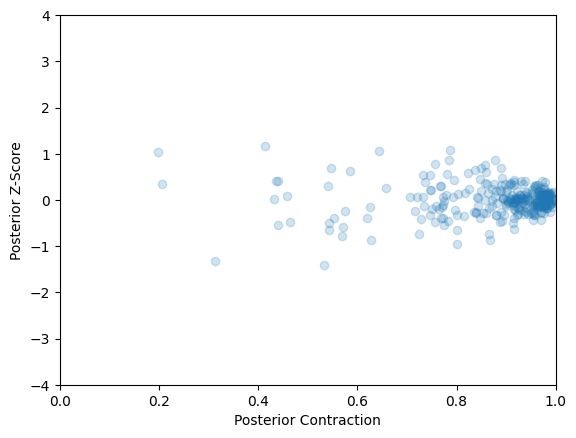

In [10]:

df_temp=df_temp[df_temp['means']!=0]
plt.scatter(df_temp['contraction'], df_temp['z_score'], alpha=.2)
plt.xlim(0,1)
plt.ylim(-4, 4)
plt.xlabel('Posterior Contraction')
plt.ylabel('Posterior Z-Score')

# Step Twelve: Fit the Observation

Confident in the performance of our model within the scope of its own assumptions we go back to fit the observed data. 

In [11]:
#reload data, parameters

params = json.load(open('params.json'))
df = pd.read_excel(params['data']['adj_location'])
df.head()


,Unnamed: 0,ResponseId,country,cond,condName,Intervention_order,Belief1,Belief2,Belief3,Belief4,...,Indirect_SES,MacArthur_SES,PerceivedSciConsensu_1,Intro_Timer,WEPTcc,BeliefCC,PolicyCC,Country,UniqueID,BeliefADJ
0,0,R_1r7Yr7R1xMimIvj,usa,5,CollectAction,BeliefinAnthrCC|SocialmediasharingPipedText|Po...,98.0,77.0,86.0,93.0,...,"2,4,5",7.0,80.0,6.056,1,88.50,89.000000,usa,0,1.601461
1,1,R_2ATgV5VxewrTRiI,usa,1,Control,PolicySupport|BeliefinAnthrCC|Socialmediashari...,49.0,50.0,51.0,51.0,...,"1,2,3,4,5,6,7",5.0,51.0,16.284,0,50.25,66.222222,usa,1,0.061524
2,2,R_3ENlePBlLyYjExr,usa,9,Letter2Future,SocialmediasharingPipedText|PolicySupport|Beli...,87.0,82.0,84.0,83.0,...,"1,2,3,6,7",8.0,73.0,5.701,1,84.00,84.222222,usa,2,1.264478
3,3,R_2c0HQgvYzas6mus,usa,4,SciConsens,PolicySupport|SocialmediasharingPipedText|Beli...,1.0,1.0,0.0,0.0,...,"1,2,3,4,5,6,7",4.0,1.0,13.282,0,0.50,1.222222,usa,3,-2.516294
4,4,R_00siryCwgdMus6J,usa,8,PluralIgnorance,BeliefinAnthrCC|SocialmediasharingPipedText|Po...,56.0,59.0,61.0,54.0,...,"1,3,5,6,7",7.0,65.0,8.474,0,57.50,80.222222,usa,4,0.300307


In [12]:
from src.models import get_WEPT_model
model, temp = get_WEPT_model(df, params['wept']['priors'])


In [13]:

with model:
    if use_cpu: 
        idata = pm.sample(cores = params['sampling']['cores'], 
                        tune = params['share']['tune'],
                        draws = params['share']['draws'], 
                        random_seed=params['seed'])
    else:
        idata = pmjax.sample_numpyro_nuts(chain_method=params['sampling']['chain_method'],
                                        postprocessing_backend=params['sampling']['postprocessing_backend'], 
                                        tune = params['wept']['tune'],
                                        draws = params['wept']['draws'], random_seed=params['seed'])
az.to_netcdf(idata, params['wept']['idata_location'])

Compiling...
Compilation time =  0:00:04.542274
Sampling...


sample: 100%|██████████| 2000/2000 [02:48<00:00, 11.87it/s]


Sampling time =  0:02:49.932993
Transforming variables...
Transformation time =  0:00:00.578078


'./out/posteriors/wept.nc'

#  Step Thirteen: Diagnose posterior fit

In [14]:
idata.sample_stats['diverging'].sum()

<xarray.DataArray 'diverging' ()>
array(0)

In [15]:
az.summary(idata, var_names=['u_t', 'u_c', 'Intercept_geom', 'Beta_geom',
                     'Intercept_theta', 'Beta_theta']).sort_values('r_hat', ascending=False)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"u_t[intercept_geom, CollectAction]",-0.013,0.052,-0.104,0.089,0.001,0.001,6713.0,3485.0,1.0
"u_c[intercept_inflated, latvia]",-0.359,0.118,-0.582,-0.132,0.001,0.001,7480.0,3313.0,1.0
"u_c[intercept_inflated, norway]",0.487,0.081,0.328,0.629,0.001,0.001,7085.0,3109.0,1.0
"u_c[intercept_inflated, northmacedonia]",-0.560,0.131,-0.792,-0.300,0.002,0.001,6781.0,2667.0,1.0
"u_c[intercept_inflated, nigeria]",0.344,0.103,0.153,0.543,0.001,0.001,6848.0,2989.0,1.0
...,...,...,...,...,...,...,...,...,...
"u_c[intercept_geom, taiwan]",-0.563,0.276,-1.122,-0.092,0.003,0.003,6413.0,3120.0,1.0
"u_c[intercept_geom, switzerland]",0.029,0.121,-0.200,0.257,0.002,0.002,6494.0,3082.0,1.0
"u_c[intercept_geom, sweden]",-0.331,0.067,-0.459,-0.210,0.001,0.001,6131.0,3160.0,1.0
"u_c[intercept_geom, sudan]",-0.189,0.143,-0.439,0.096,0.002,0.001,7719.0,2798.0,1.0


In [16]:
az.bfmi(idata)

array([0.90791853, 0.9629561 , 1.09573484, 1.12653768])

#  Step Fourteen: Posterior Retrodictive Fit

In [17]:
with model:
   ppc = pm.sample_posterior_predictive(idata, var_names=["y_out"])


Sampling: [y_out]


In [18]:
temp['y_hat'] = ppc.posterior_predictive['y_out'].mean(dim=['chain', 'draw'])
temp['count'] = np.ones(temp.shape[0])

grouped = temp.groupby(['condName', 'Country']).mean().reset_index()
group_count = temp.groupby(['condName', 'Country']).count().reset_index()

/tmp/ipykernel_116071/1536785464.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = temp.groupby(['condName', 'Country']).mean().reset_index()


In [19]:
idata.extend(ppc)

idata.rename({'y_out_dim_0':'obs_id', 'y_out_dim_2':'obs_id'}, inplace=True)
idata = idata.assign_coords(obs_id=temp['condName'].values,  groups="observed_vars")


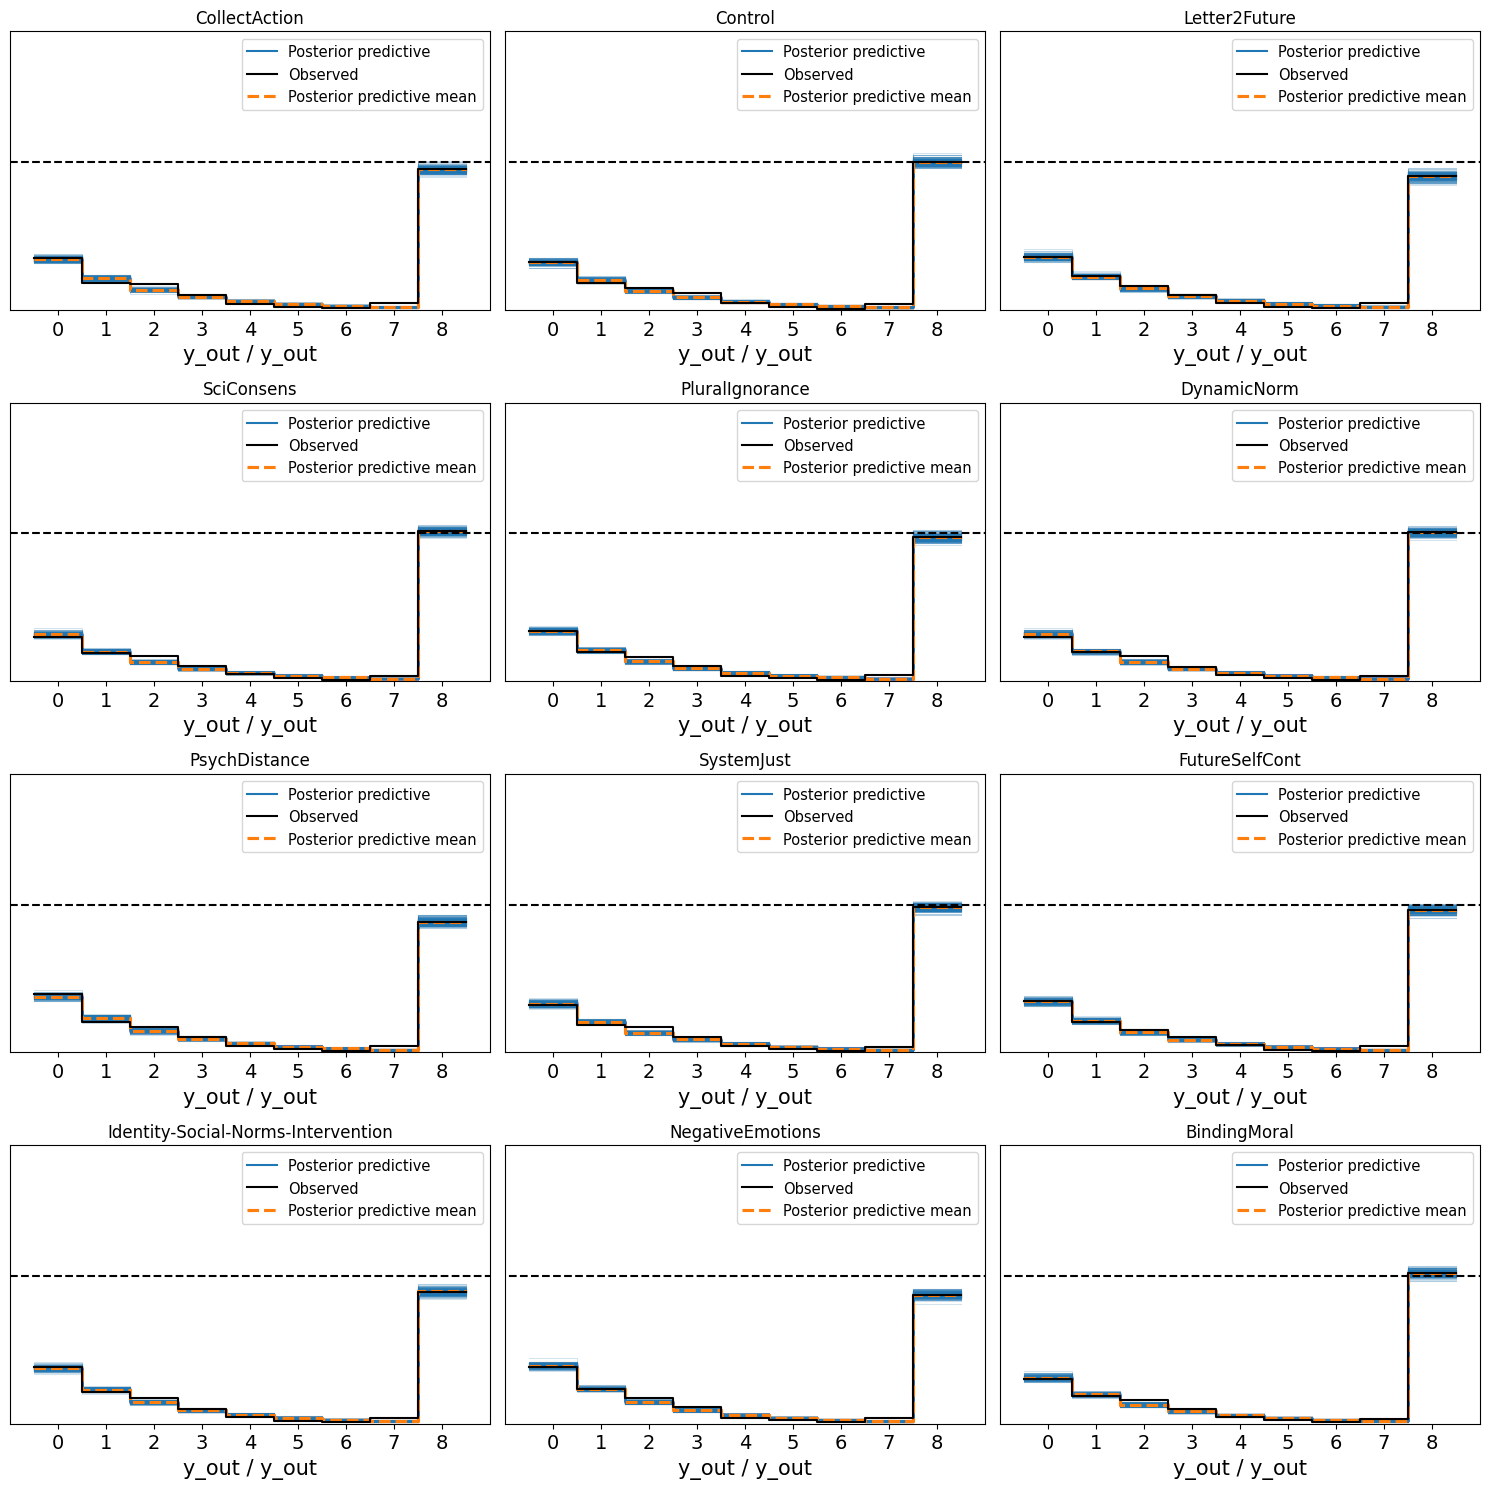

In [20]:
g = plt.GridSpec(4, 3, figure=plt.figure(figsize=(15, 15)))

mu = np.mean((idata.posterior_predictive.sel(obs_id='Control')['y_out']==9).data)
condName = temp['condName'].unique()[0]
for i, condName in enumerate(temp['condName'].unique()):
    ax = plt.subplot(g[i//3, i%3])
    az.plot_ppc(idata, coords={'obs_id': [condName]}, num_pp_samples=200, ax=ax)
    ax.set_title(condName)
    ax.set_xticks(np.arange(1, 10)+.5, np.arange(0, 9))
    plt.plot([-10,20], [mu,mu], ls='--', color='k')
    plt.xlim(0.5, 10.5)
plt.tight_layout()

#Find the largest y axis size and set all to that size
max_ylim = (1)
for ax in plt.gcf().axes:
    ylim = ax.get_ylim()
    if ylim[1] > max_ylim:
        max_ylim = ylim[1]
for ax in plt.gcf().axes:
    ax.set_ylim(0, max_ylim)


plt.savefig('./out/wept_ppc.png', dpi=300)

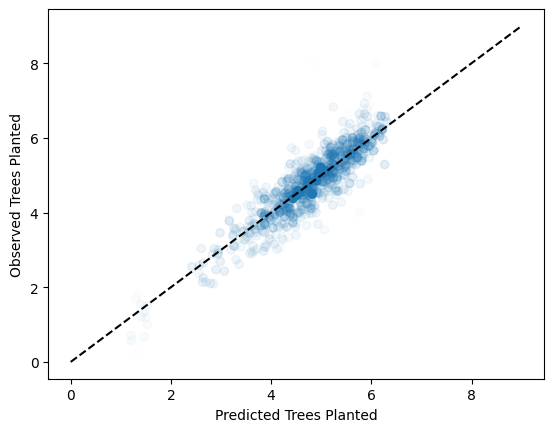

In [21]:
plt.scatter( grouped['y_hat']-1, grouped['WEPT']-1,
            alpha=group_count['count']/np.max(group_count['count']))

plt.plot([0, 9], [0, 9], ls='--',color='k')
plt.xlabel('Predicted Trees Planted')
plt.ylabel('Observed Trees Planted')
plt.savefig('./out/wept_scatter.png', dpi=300)